# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageFilter
import pandas as pd
import os
import io
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi
import pywt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, Resizing, GlobalAveragePooling2D
from keras.applications import ResNet50, MobileNet, VGG16
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

K.clear_session()
tf.compat.v1.reset_default_graph()
tf.compat.v1.enable_eager_execution()

## Downloading the dataset

In [32]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

In [33]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Dataset already Downloaded.


In [34]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"
IMG_SIZE = (128, 128)
CLASS = ['Manipulated', 'Original']

In [35]:
cabezera = "category", "image", "real"
df_au = pd.DataFrame(columns=cabezera)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img = cv2.imread(os.path.join(REAL_IMAGE_PATH, file))
    img = cv2.resize(img, IMG_SIZE)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img,  1]], columns=cabezera)], ignore_index=True)

df_au.head()

,category,image,real
0,ani,"[[[222, 181, 72], [219, 179, 73], [216, 175, 7...",1
1,ani,"[[[149, 126, 113], [139, 115, 104], [158, 125,...",1
2,ani,"[[[0, 10, 8], [19, 36, 25], [7, 30, 11], [29, ...",1
3,ani,"[[[41, 20, 22], [40, 22, 23], [41, 23, 24], [3...",1
4,ani,"[[[80, 22, 10], [83, 23, 11], [84, 25, 10], [8...",1


In [36]:
#remove categoriy txt because it is not in the dataset
df_au = df_au[df_au.category != "txt"]
df_au = df_au[df_au.category != "ind"]
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

In [37]:
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

Realizaremos el mismo proceso con las imagenes modificadas

In [38]:
cabezera = "category", "image", "region", "real"
key_list = ["ani", "arc", "art", "cha", "nat", "pla", "sec"]
df_tp = pd.DataFrame(columns=cabezera)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img = cv2.imread(os.path.join(FAKE_IMAGE_PATH, file))
    img = cv2.resize(img, IMG_SIZE)
    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img, category[1], 0]], columns=cabezera)], ignore_index=True)

df_tp.head()

,category,image,region,real
0,ani,"[[[193, 170, 150], [197, 174, 154], [194, 174,...",D,0
1,art,"[[[8, 12, 17], [8, 12, 17], [9, 13, 18], [6, 1...",D,0
2,art,"[[[187, 179, 179], [128, 135, 144], [131, 148,...",D,0
3,ani,"[[[54, 84, 65], [69, 94, 84], [53, 78, 74], [5...",D,0
4,ind,"[[[8, 13, 11], [16, 13, 15], [13, 12, 14], [10...",D,0


In [39]:
df_tp = df_tp[df_tp.category != "txt"]
df_tp = df_tp[df_tp.category != "ind"]
df_tp = df_tp.sample(frac=1).reset_index(drop=True)

In [40]:
df = pd.concat([df_au, df_tp], ignore_index=True)

In [41]:
def wavelet(image):
    # Convertir la imagen a escala de grises
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar la transformada de wavelet
    coeffs = pywt.dwt2(gris, 'haar')
    LL, (LH, HL, HH) = coeffs
    
    # Aplicar la transformada inversa de wavelet
    reconstruccion = pywt.idwt2(coeffs, 'haar')

    resta = gris - reconstruccion
    
    return resta

## Creating Model

### Creating and splitting the dataset

In [48]:
# Preprocesar las imágenes
preprocessed = [wavelet(image) for image in df['image']]

# Convertir las imágenes a tensores de tensorflow
tensors = [tf.convert_to_tensor(image) for image in preprocessed]
tensors_y = [tf.convert_to_tensor(real) for real in df['real']]

In [49]:
X = np.array(tensors)
Y = np.array(tensors_y)


# Dividir el conjunto de datos en entrenamiento validacion y prueba
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


### Creating the checkpoints

In [50]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)


model_chekpoint = ModelCheckpoint(
    filepath='./../model/checkpoints', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

tensor_board = TensorBoard(
    log_dir='./../model/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [early_stopping, model_chekpoint, tensor_board]
optimizer = Adam(learning_rate=0.0001)

### Creating the model fron scratch

detect_manipulated_images_model_scratch_v1.h5 2min 5s 13 epocas bacth_size=32

loss: 0.6631 - accuracy: 0.6224 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.3776

In [51]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation=None, input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Training the model

In [52]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/50
228/228 [==============================] - 19s 45ms/step - loss: 2.4341 - accuracy: 0.6125 - precision: 0.6137 - recall: 0.9953 - auc: 0.4887 - prc: 0.6041 - val_loss: 0.9032 - val_accuracy: 0.6047 - val_precision: 0.6047 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.6047
Epoch 2/50
228/228 [==============================] - 9s 41ms/step - loss: 0.7585 - accuracy: 0.6139 - precision: 0.6139 - recall: 1.0000 - auc: 0.5014 - prc: 0.6156 - val_loss: 0.6951 - val_accuracy: 0.6047 - val_precision: 0.6047 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.6047
Epoch 3/50
228/228 [==============================] - 9s 41ms/step - loss: 0.6773 - accuracy: 0.6139 - precision: 0.6139 - recall: 1.0000 - auc: 0.4979 - prc: 0.6134 - val_loss: 0.6734 - val_accuracy: 0.6047 - val_precision: 0.6047 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.6047
Epoch 4/50
228/228 [==============================] - 9s 41ms/step - loss: 0.6682 - accuracy: 0.6139 - precision: 0.6139 - recall: 1

### Evaluating the model

In [53]:
model.evaluate(x_test, y_test)

72/72 [==============================] - 2s 15ms/step - loss: 0.6629 - accuracy: 0.6224 - precision: 0.6224 - recall: 1.0000 - auc: 0.5000 - prc: 0.6224


[0.6629449129104614,
 0.6223683953285217,
 0.6223683953285217,
 1.0,
 0.5,
 0.6223683953285217]

### Showing the results

In [54]:
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'prc', 'precision', 'recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 10))
    
    for i, metric in enumerate(metrics):
        axes[i].plot(history.history[metric], label='train')
        axes[i].plot(history.history[f'val_{metric}'], label='val')
        axes[i].set_title(metric)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X, y_true):
    y_pred = model.predict(X) > 0.5
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap=plt.cm.Reds)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.xticks([0, 1], ['Manipulated', 'Original'], fontsize=12)
    plt.yticks([0, 1], ['Manipulated', 'Original'], fontsize=12)
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', fontsize=20)
    plt.show()

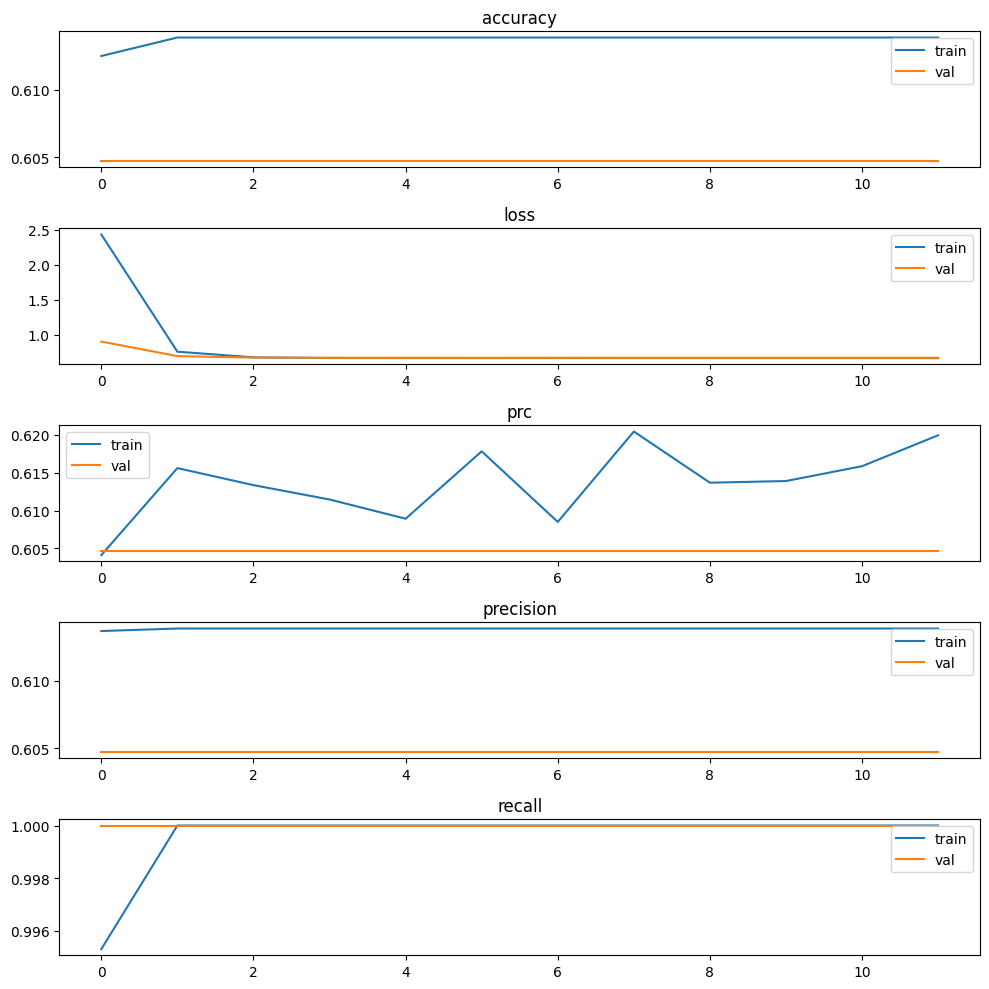

In [55]:
plot_metrics(history)

72/72 [==============================] - 1s 13ms/step


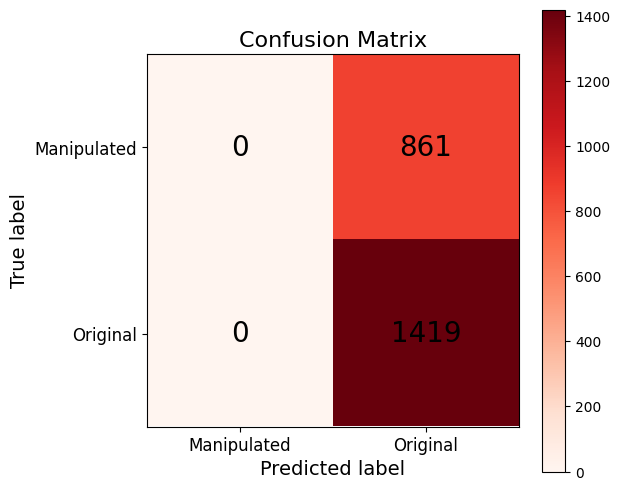

In [56]:
plot_confusion_matrix(model, x_test, y_test)

In [57]:
model.save('./../model/wavelet_models/detect_manipulated_images_model_scratch.h5')